In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)

In [2]:
# reading in data

brownlow = pd.read_csv("brownlow_datathon_data.csv")
brownlow = brownlow.drop(columns="Unnamed: 0")
brownlow['date'] = pd.to_datetime(brownlow['date'], format="%d/%m/%Y")

# get non 2018 data for testing

df = brownlow[brownlow['season'] != 2019]

In [3]:
df.tail()

,date,season,round,venue,ID,match_id,player,jumper_no,team,opposition,status,team_score,opposition_score,margin,brownlow_votes,CP,UP,ED,DE,CM,GA,MI5,one_perc,BO,TOG,K,HB,D,M,G,B,T,HO,I50,CL,CG,R50,FF,FA,AF,SC
76583,2018-08-26,2018,23,Docklands,1418,9708.0,J Waite,30,North Melbourne,St Kilda,Away,117,94,23,0.0,4.0,13.0,10.0,62.5,1.0,2.0,6.0,0.0,1.0,85.0,14.0,2.0,16.0,8.0,3.0,3.0,0.0,0.0,1.0,1.0,4.0,1.0,0.0,2.0,85.0,85.0
76584,2018-08-26,2018,23,Docklands,12084,9708.0,M Williams,2,North Melbourne,St Kilda,Away,117,94,23,0.0,5.0,15.0,15.0,83.3,0.0,0.0,0.0,3.0,1.0,83.0,12.0,6.0,18.0,4.0,0.0,0.0,2.0,0.0,2.0,0.0,1.0,2.0,1.0,0.0,69.0,77.0
76585,2018-08-26,2018,23,Docklands,12312,9708.0,M Wood,32,North Melbourne,St Kilda,Away,117,94,23,0.0,0.0,3.0,2.0,66.7,0.0,0.0,2.0,0.0,0.0,34.0,3.0,0.0,3.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,25.0
76586,2018-08-26,2018,23,Docklands,11755,9708.0,S Wright,19,North Melbourne,St Kilda,Away,117,94,23,0.0,10.0,17.0,22.0,75.9,0.0,0.0,0.0,0.0,1.0,83.0,16.0,13.0,29.0,8.0,0.0,0.0,2.0,0.0,3.0,0.0,4.0,4.0,1.0,0.0,107.0,96.0
76587,2018-08-26,2018,23,Docklands,11724,9708.0,J Ziebell,7,North Melbourne,St Kilda,Away,117,94,23,0.0,9.0,8.0,11.0,73.3,0.0,0.0,2.0,4.0,0.0,94.0,12.0,3.0,15.0,6.0,3.0,1.0,2.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,89.0,109.0


In [4]:
df.columns

Index(['date', 'season', 'round', 'venue', 'ID', 'match_id', 'player',
       'jumper_no', 'team', 'opposition', 'status', 'team_score',
       'opposition_score', 'margin', 'brownlow_votes', 'CP', 'UP', 'ED', 'DE',
       'CM', 'GA', 'MI5', 'one_perc', 'BO', 'TOG', 'K', 'HB', 'D', 'M', 'G',
       'B', 'T', 'HO', 'I50', 'CL', 'CG', 'R50', 'FF', 'FA', 'AF', 'SC'],
      dtype='object')

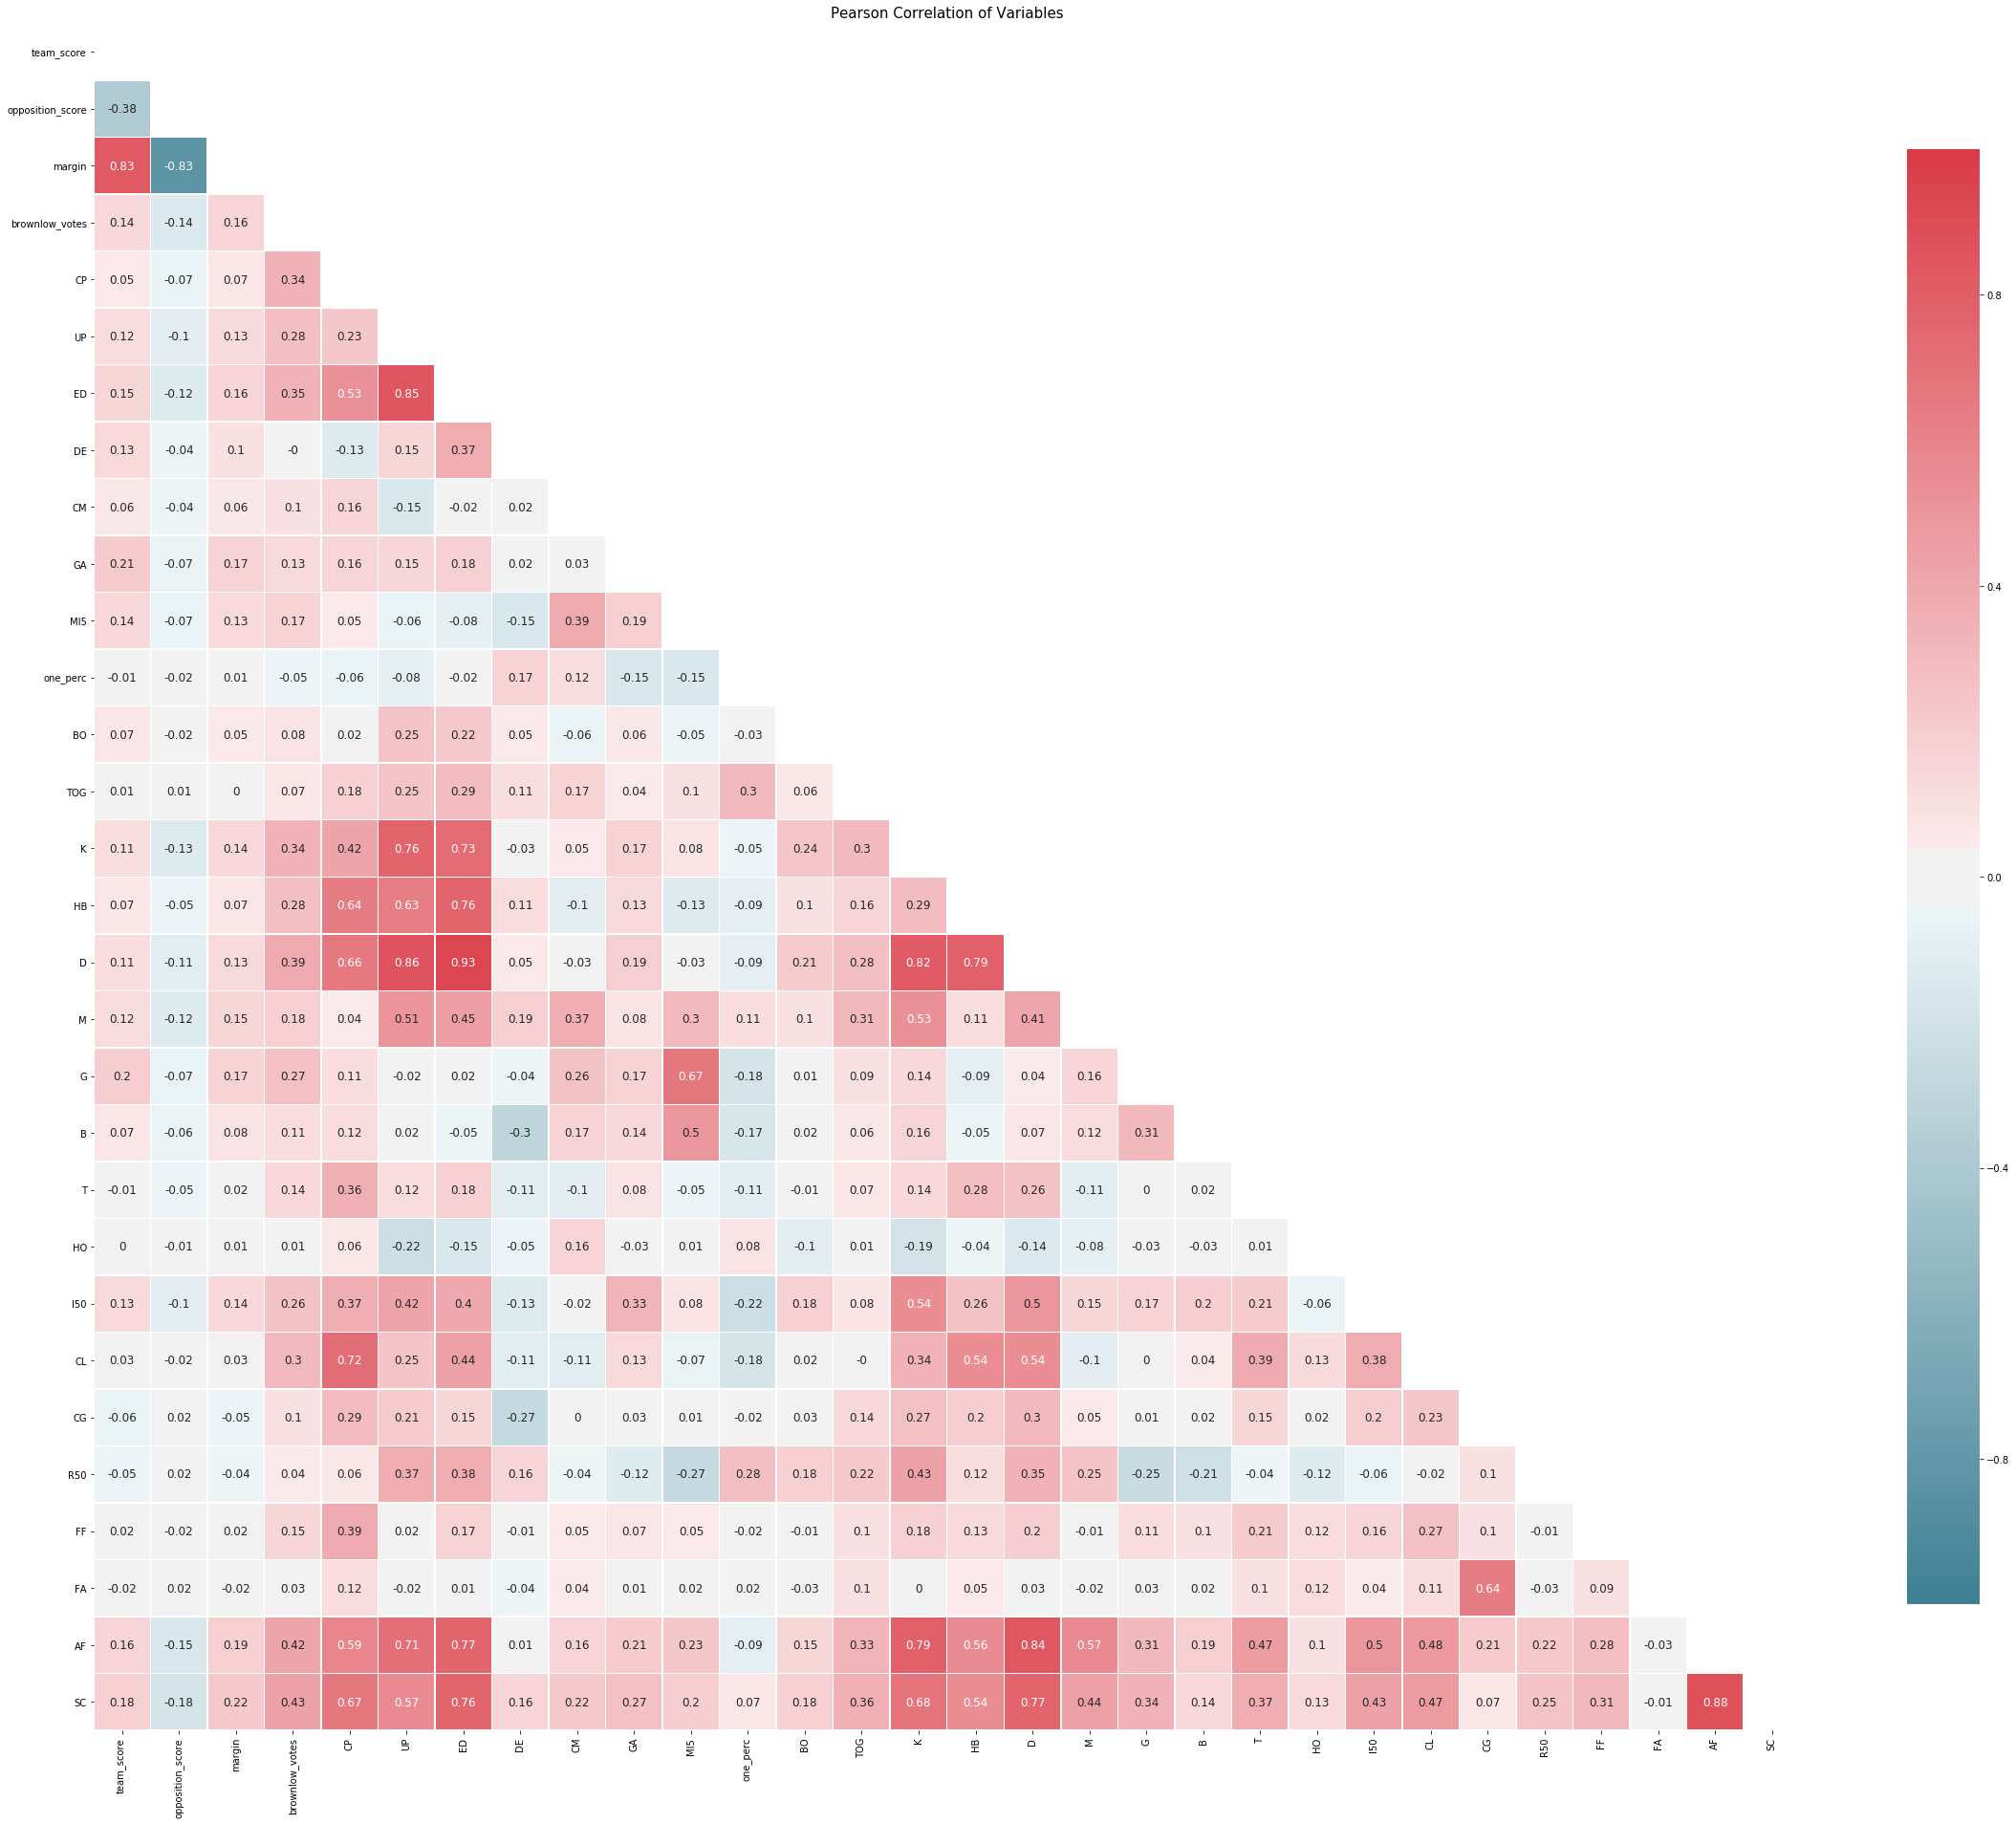

In [5]:
# check out correlation of features:

def corr_plot(df, title_name):
    _ , ax = plt.subplots(figsize=(40, 40))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    
    corr = round(df.corr(),2)
    # Generate a mask for the lower triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    
    _ = sns.heatmap(
        corr, mask=mask, cmap=cmap,
        square=True, 
        cbar_kws={'shrink':.7},
        
        ax=ax,
        annot=True, 
        linewidths=0.5,
        vmax=1.0, vmin=-1.0, linecolor='white',
        annot_kws={'fontsize':12 }
    )
    
    plt.title(title_name, y=1.05, size=15)

not_feature_cols = ['date', 'season', 'round', 'venue', 'ID', 'match_id', 'player', 'jumper_no', 'team', 'opposition', 'status']
    
features = [col for col in df.columns if col not in not_feature_cols]
corr_plot(df[features], title_name='Pearson Correlation of Variables')

In [6]:
corr = df[features].corr()

In [7]:
corr_cols = corr.abs().loc[:,corr["brownlow_votes"] > 0.3].columns[1:]
#feat_cols = [col for col in corr_cols if col != "brownlow_votes"]
feat_cols = [col for col in features if col != "brownlow_votes"]
feat_cols.remove("team_score")
feat_cols.remove("opposition_score")

In [8]:
feat_cols

['margin',
 'CP',
 'UP',
 'ED',
 'DE',
 'CM',
 'GA',
 'MI5',
 'one_perc',
 'BO',
 'TOG',
 'K',
 'HB',
 'D',
 'M',
 'G',
 'B',
 'T',
 'HO',
 'I50',
 'CL',
 'CG',
 'R50',
 'FF',
 'FA',
 'AF',
 'SC']

In [378]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import lightgbm as lgb

# split test and train datasets

train = df[df['season'] < 2018]
test = df[df['season'] == 2018]

X_train = train[feat_cols]
y_train = train['brownlow_votes']

X_test = test[feat_cols]
y_test = test['brownlow_votes']

In [379]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

def objective(space):
    # Scale features
    scaler = StandardScaler()
    X_train_sc = scaler.fit_transform(X_train)
    X_test_sc = scaler.transform(X_test)
    
    # Instantiate the model
    reg = lgb.LGBMRegressor(boosting_type = 'gbdt',
                            learning_rate = space['learning_rate'],
                            reg_alpha = space['reg_alpha'],
                            reg_lambda = space['reg_lambda'],
                            num_leaves = int(space['num_leaves']),
                            max_depth = int(space['max_depth']),
                            min_child_samples = int(space['min_child_samples']),
#                             max_bin = space['max_bin'],
#                             bagging_freq = space['bagging_freq'],
#                             bagging_fraction = space['bagging_freq'],
#                             feature_fraction = space['feature_fraction']
                            )
    
    # Fit the model and generate predictions
    reg.fit(X_train_sc, y_train)
    preds = reg.predict(X_test_sc)
    
    # Combine predictions with test data
    results = pd.DataFrame({
        'player': test['player'],
        'votes': test['brownlow_votes'],
        'votes_pred': preds
    })
    results = results.groupby('player')[['votes', 'votes_pred']].sum()
    results[results['votes_pred'] < 0] = 0
    results['mse'] = (results['votes_pred'] - results['votes'])**2
    mse = results['mse'].sum()
    
    # return needs to be in this format. We use negative loss to maximise or +ve to minimise
    return {'loss': mse, 'status': STATUS_OK }

In [380]:
# create search space for hyperparameters

space = {
    
    #'boosting_type': hp.choice('x_boosting_type', ['gbdt', 'dart']),
    'learning_rate': hp.uniform('x_learning_rate', 0.4, 0.7),
    'max_depth': hp.quniform('x_max_depth', 4, 12, 1),
    'reg_alpha': hp.uniform('x_reg_alpha', 0, 0.3),
    'reg_lambda': hp.uniform('x_reg_lambda', 0, 0.6),
    'num_leaves': hp.quniform('x_num_leaves', 40, 90, 1),
    'min_child_samples': hp.quniform('x_min_child_samples', 1400, 1850, 1),
#     'max_bin': hp.uniform('x_max_bin',),
#     'bagging_freq': hp.choice('x_bagging_freq', range(0,11)),
#     'bagging_fraction': hp.uniform('x_bagging_fraction', 0.2, 1.0),
#     'feature_fraction': hp.quniform('x_feature_fraction', 0.5, 1.0, 2)
    
}


In [381]:
# from hyperopt import pyll
# print(pyll.stochastic.sample(space))

In [382]:
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=1000,
            trials=trials)
print(best)

100%|██████████| 1000/1000 [09:11<00:00,  1.65it/s, best loss: 1571.6689555339503]
{'x_learning_rate': 0.5831801641952704, 'x_max_depth': 11.0, 'x_min_child_samples': 1668.0, 'x_num_leaves': 83.0, 'x_reg_alpha': 0.1587636489101374, 'x_reg_lambda': 0.12186942631908809}


In [357]:
# save best params (from 2017 testing)

params_2017 = {
    'learning_rate': 0.6176419883200992, 
    'max_depth': 7, 
    'min_child_samples': 1822, 
    'num_leaves': 51, 
    'reg_alpha': 0.15619467702173398, 
    'reg_lambda': 0.4593869839349962
}

In [386]:
# save best params (from 2018 testing)

params = {
    'learning_rate': 0.5831801641952704, 
    'max_depth': 11, 
    'min_child_samples': 1668, 
    'num_leaves': 83, 
    'reg_alpha': 0.1587636489101374, 
    'reg_lambda': 0.12186942631908809
}

In [290]:
# for t in trials:
#     print(t)
#     print('\n')

In [244]:
y_lims = [1500,2000]

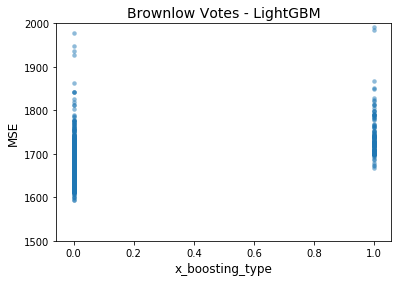

In [263]:
# f, ax = plt.subplots(1)
# xs = [t['misc']['vals']['x_boosting_type'] for t in trials.trials]
# ys = [t['result']['loss'] for t in trials.trials]
# ax.scatter(xs, ys, s=20, linewidth=0.01, alpha=0.5)
# ax.set_ylim(y_lims)
# ax.set_title('Brownlow Votes - LightGBM', fontsize=14)
# ax.set_xlabel('x_boosting_type', fontsize=12)
# ax.set_ylabel('MSE', fontsize=12);

# tests showed 'gbdt' to perform best

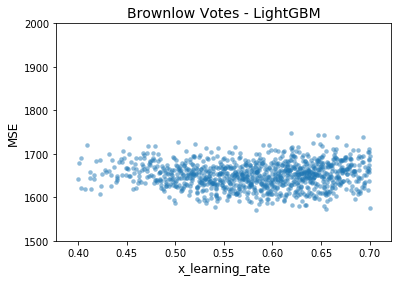

In [387]:
f, ax = plt.subplots(1)
xs = [t['misc']['vals']['x_learning_rate'] for t in trials.trials]
ys = [t['result']['loss'] for t in trials.trials]
ax.scatter(xs, ys, s=20, linewidth=0.01, alpha=0.5)
ax.set_ylim(y_lims)
ax.set_title('Brownlow Votes - LightGBM', fontsize=14)
ax.set_xlabel('x_learning_rate', fontsize=12)
ax.set_ylabel('MSE', fontsize=12);

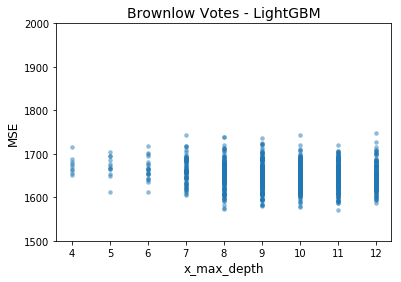

In [388]:
f, ax = plt.subplots(1)
xs = [t['misc']['vals']['x_max_depth'] for t in trials.trials]
ys = [t['result']['loss'] for t in trials.trials]
ax.scatter(xs, ys, s=20, linewidth=0.01, alpha=0.5)
ax.set_ylim(y_lims)
ax.set_title('Brownlow Votes - LightGBM', fontsize=14)
ax.set_xlabel('x_max_depth', fontsize=12)
ax.set_ylabel('MSE', fontsize=12);

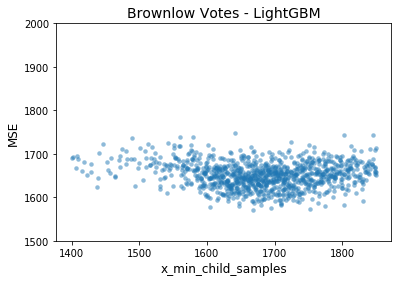

In [389]:
f, ax = plt.subplots(1)
xs = [t['misc']['vals']['x_min_child_samples'] for t in trials.trials]
ys = [t['result']['loss'] for t in trials.trials]
ax.scatter(xs, ys, s=20, linewidth=0.01, alpha=0.5)
ax.set_ylim(y_lims)
ax.set_title('Brownlow Votes - LightGBM', fontsize=14)
ax.set_xlabel('x_min_child_samples', fontsize=12)
ax.set_ylabel('MSE', fontsize=12);

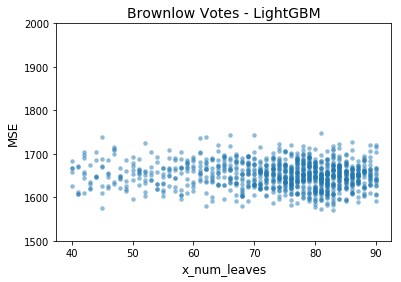

In [390]:
f, ax = plt.subplots(1)
xs = [t['misc']['vals']['x_num_leaves'] for t in trials.trials]
ys = [t['result']['loss'] for t in trials.trials]
ax.scatter(xs, ys, s=20, linewidth=0.01, alpha=0.5)
ax.set_ylim(y_lims)
ax.set_title('Brownlow Votes - LightGBM', fontsize=14)
ax.set_xlabel('x_num_leaves', fontsize=12)
ax.set_ylabel('MSE', fontsize=12);

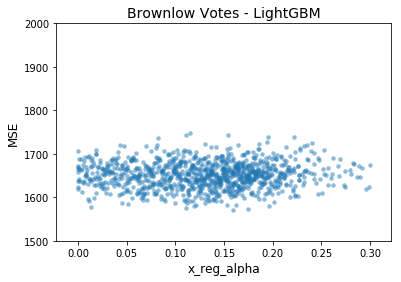

In [391]:
f, ax = plt.subplots(1)
xs = [t['misc']['vals']['x_reg_alpha'] for t in trials.trials]
ys = [t['result']['loss'] for t in trials.trials]
ax.scatter(xs, ys, s=20, linewidth=0.01, alpha=0.5)
ax.set_ylim(y_lims)
ax.set_title('Brownlow Votes - LightGBM', fontsize=14)
ax.set_xlabel('x_reg_alpha', fontsize=12)
ax.set_ylabel('MSE', fontsize=12);

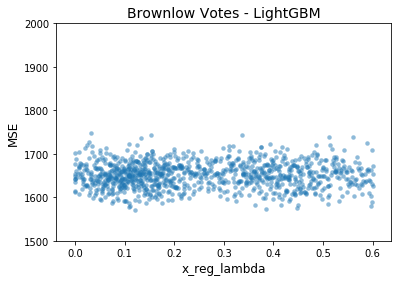

In [392]:
f, ax = plt.subplots(1)
xs = [t['misc']['vals']['x_reg_lambda'] for t in trials.trials]
ys = [t['result']['loss'] for t in trials.trials]
ax.scatter(xs, ys, s=20, linewidth=0.01, alpha=0.5)
ax.set_ylim(y_lims)
ax.set_title('Brownlow Votes - LightGBM', fontsize=14)
ax.set_xlabel('x_reg_lambda', fontsize=12)
ax.set_ylabel('MSE', fontsize=12);

---
#### EVALUATING HYPERPARAMETER OPTIMISATION ON 2018 DATA

In [393]:
# Use best hyperparamaters from optimization

# split test and train datasets
train = df[df['season'] < 2018]
test = df[df['season'] == 2018]

X_train = train[feat_cols]
y_train = train['brownlow_votes']

X_test = test[feat_cols]
y_test = test['brownlow_votes']

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Instantiate and fit model
lgb_reg = lgb.LGBMRegressor(**params)
lgb_reg.fit(X_train_scaled, y_train)

# Create predictions
preds = lgb_reg.predict(X_test_scaled)

In [428]:
results = pd.DataFrame({
    'player': test['player'],
    'votes': test['brownlow_votes'],
    'votes_pred': preds
})

results = results.groupby('player')[['votes', 'votes_pred']].sum().sort_values(by='votes', ascending=False)

# can't get -ve votes so change all -ve to 0
results[results['votes_pred'] < 0] = 0

results['mse'] = (results['votes_pred'] - results['votes'])**2

print(results['mse'].sum())
results.head(20)

# prev results predicting 2018 MSE: 1569.64

1571.6689555339503


,votes,votes_pred,mse
player,,,
T Mitchell,28.0,32.446744,19.773534
S Sidebottom,24.0,17.075224,47.952519
A Brayshaw,21.0,12.916521,65.342628
P Cripps,20.0,15.749839,18.063865
M Gawn,20.0,15.665910,18.784336
D Martin,19.0,17.514226,2.207524
R Laird,19.0,12.058112,48.189811
J Steven,18.0,10.963642,49.510334
D Beams,18.0,17.227553,0.596675


In [429]:
results.sort_values(by='mse', ascending=False).head()

,votes,votes_pred,mse
player,,,
A Brayshaw,21.0,12.916521,65.342628
T Phillips,0.0,7.703660,59.346373
J Steven,18.0,10.963642,49.510334
R Laird,19.0,12.058112,48.189811
S Sidebottom,24.0,17.075224,47.952519


---
#### CREATING 2019 PREDICTIONS

In [438]:
# predictions for 2019

val_train = brownlow[brownlow['season'] < 2019]
val_test = brownlow[brownlow['season'] == 2019]

X_val_train = val_train[feat_cols]
y_val_train = val_train['brownlow_votes']

X_val_test = val_test[feat_cols]

# Scale features
scaler = StandardScaler()
X_val_train_scaled = scaler.fit_transform(X_val_train)
X_val_test_scaled = scaler.transform(X_val_test)

# Instantiate and fit model
lgb_reg = lgb.LGBMRegressor(**params)
lgb_reg.fit(X_val_train_scaled, y_val_train)
#lgb_reg.fit(X_val_train, y_val_train)

# Create predictions
val_preds = lgb_reg.predict(X_val_test_scaled)
#preds = lgb_reg.predict(X_test)

preds_v3 = pd.DataFrame({
    'preds': val_preds
})

val = val_test[['player']].reset_index(drop=True)
val = val.join(preds_v3)



val = val.groupby('player')[['preds']].sum().sort_values('preds', ascending=False)

val[val['preds'] < 0] = 0

val.head(20)

,preds
player,
P Dangerfield,24.868250
J Macrae,24.731312
A Treloar,23.877910
L Neale,20.085018
B Grundy,18.658105
J Dunkley,18.149156
D Martin,17.856190
N Fyfe,17.840834
T Taranto,17.580215


In [439]:
# formatting for submission

val = val.sort_values('player', ascending=True)
val.reset_index(drop=False, inplace=True)
val = val.rename(columns={'player': 'PLAYER', 'preds': 'PREDICTION'})
val.head()

,PLAYER,PREDICTION
0,A Aliir,0.288976
1,A Bonar,0.003210
2,A Brayshaw,3.219645
3,A Bullen,0.000000
4,A Cerra,0.018838


In [440]:
val.to_csv('brownlow-datathon-submission.csv', index=False)